In [1]:
import pandas_gbq
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

# Customer level [WIP]

Investigate:
- Avg Share of orders incentivised
- Avg Incentive value used per incentivised order 
- Avg Incentive Amount/Basket Value (AOV + Delivery + Service Fee) 


In [27]:
q_cust = '''
SELECT analytical_customer_id,global_entity_id, order_id,
  CASE WHEN (is_discount OR is_voucher OR is_joker)
    THEN 1 else 0 end as used_incentive,  
  CASE WHEN is_free_delivery
    THEN 1 else 0 end as has_free_delivery,  
  IFNULL(value.incentives.voucher_total_eur,0)+IFNULL(value.incentives.discount_total_eur, 0) AS incentive_value,
  value.order.gmv_eur as basket_value 
FROM `fulfillment-dwh-production.curated_data_shared_coredata_business.orders` left join unnest(addons.subscriptions) as ad
WHERE is_successful = true and global_entity_id="FO_NO" and date(partition_date_local) between "2023-01-01" and "2023-12-31" and is_corporate = false and ad.subscription_id is null
'''

In [28]:
df_customer = pandas_gbq.read_gbq(q_cust)


Downloading:   0%|          |
Downloading:   3%|▎         |
Downloading:   3%|▎         |
Downloading:   5%|▌         |
Downloading:   5%|▌         |
Downloading:   8%|▊         |
Downloading:   8%|▊         |
Downloading:  10%|█         |
Downloading:  10%|█         |
Downloading:  13%|█▎        |
Downloading:  13%|█▎        |
Downloading:  15%|█▌        |
Downloading:  15%|█▌        |
Downloading:  18%|█▊        |
Downloading:  18%|█▊        |
Downloading:  21%|██        |
Downloading:  21%|██        |
Downloading:  23%|██▎       |
Downloading:  23%|██▎       |
Downloading:  26%|██▌       |
Downloading:  26%|██▌       |
Downloading:  28%|██▊       |
Downloading:  28%|██▊       |
Downloading:  31%|███       |
Downloading:  31%|███       |
Downloading:  33%|███▎      |
Downloading:  33%|███▎      |
Downloading:  36%|███▌      |
Downloading:  36%|███▌      |
Downloading:  38%|███▊      |
Downloading:  38%|███▊      |
Downloading:  41%|████      |
Downloading:  41%|████      |
Downloadi

In [29]:
df_customer.columns

Index(['analytical_customer_id', 'global_entity_id', 'order_id',
       'used_incentive', 'has_free_delivery', 'incentive_value',
       'basket_value'],
      dtype='object')

In [33]:
df_customer['analytical_customer_id'].nunique()

754216

## Avg share of orders incentivized

In [85]:
df_incentivized = df_customer.groupby('analytical_customer_id')[['used_incentive', 'has_free_delivery']].mean().reset_index()

In [86]:
len(df_incentivized[df_incentivized['used_incentive']>0])/len(df_incentivized)

0.5627021967181816

Distribution of incentivized orders per customer:

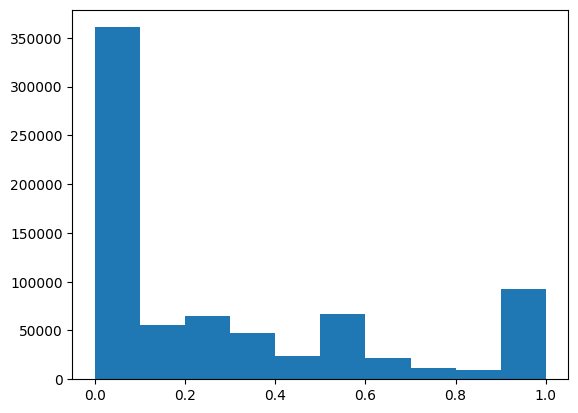

In [93]:
plt.hist(df_incentivized['used_incentive']);

In [88]:
len(df_incentivized[df_incentivized['has_free_delivery']>0])/len(df_incentivized)

0.6425692374598259

Distribution of free delivery orders per customer:

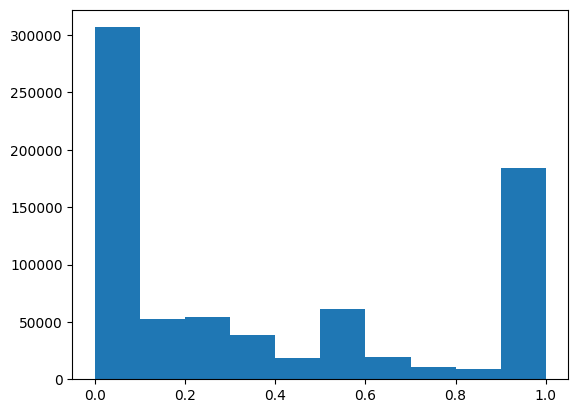

In [92]:
plt.hist(df_incentivized['has_free_delivery']);

In one year, 56% customers used an incentive at least once, and 64% of them placed orders with free delivery.

## Avg incentive value per order

In [53]:
df_avg_order = df_customer[df_customer['used_incentive']==1].groupby('analytical_customer_id')['incentive_value'].mean().reset_index()

Distribution of incentive values:

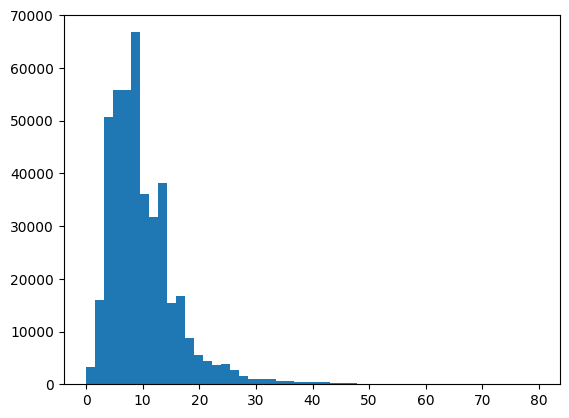

In [76]:
plt.hist(df_avg_order[df_avg_order['incentive_value']<80]['incentive_value'], bins=50);

## Avg incentive amount basket

In [56]:
df_avg_basket = df_customer[df_customer['used_incentive']==1].groupby('analytical_customer_id')['basket_value'].mean().reset_index()

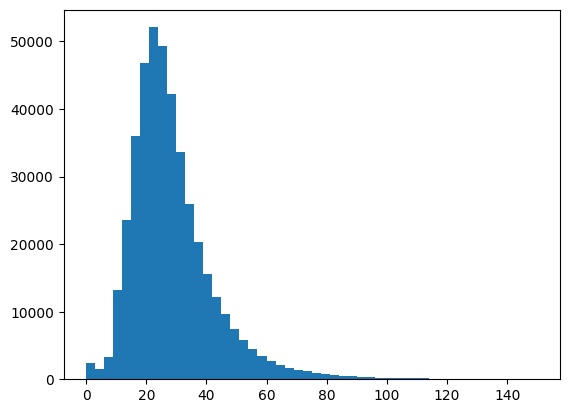

In [78]:
plt.hist(df_avg_basket[df_avg_basket['basket_value']<150]['basket_value'], bins=50);

In [217]:
def min_max_norm(df, col):
    return (df[col]-df[col].min())/(df[col].max()-df[col].min())

In [218]:
df_median_sol_ = df_incentivized.merge(df_avg_basket, on='analytical_customer_id')
df_median_sol = df_median_sol_.merge(df_avg_order, on='analytical_customer_id')

Simple solution:

In [219]:
df_median_sol['simple_score'] = 0.5*df_median_sol['used_incentive']+0.3*min_max_norm(df_median_sol, 'incentive_value')+0.3*min_max_norm(df_median_sol, 'basket_value')

In [220]:
print(df_median_sol['simple_score'].min(), df_median_sol['simple_score'].max())

0.013731896896026606 0.9733129846559974


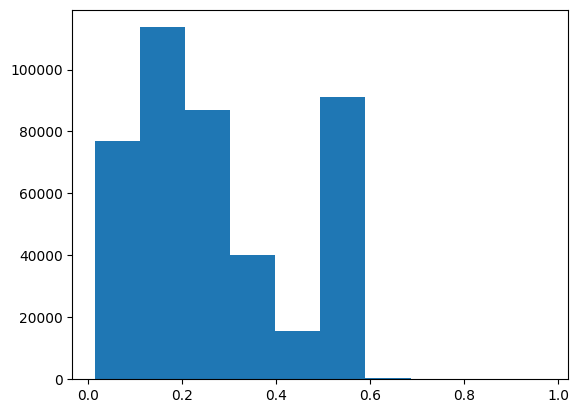

In [221]:
plt.hist(df_median_sol['simple_score']);

Median solution:

In [222]:
order_value_median = df_median_sol['incentive_value'].median()
basket_value_median = df_median_sol['basket_value'].median()
incentive_use_median = df_median_sol['used_incentive'].median()

In [223]:
df_median_sol['order_score']= df_median_sol['incentive_value']-order_value_median
df_median_sol['basket_score']= df_median_sol['basket_value']-basket_value_median
df_median_sol['incentive_use_score']= df_median_sol['used_incentive']-incentive_use_median

In [224]:
df_median_sol['median_score'] = 0.3*df_median_sol['order_score']+0.2*df_median_sol['basket_score']+0.5*df_median_sol['incentive_use_score']
df_median_sol['median_score_normalized'] = 2 * min_max_norm(df_median_sol, 'median_score')-1

In [206]:
print(df_median_sol['median_score_normalized'].min(), df_median_sol['median_score_normalized'].max())

-1.0 1.0


Median score distribution:

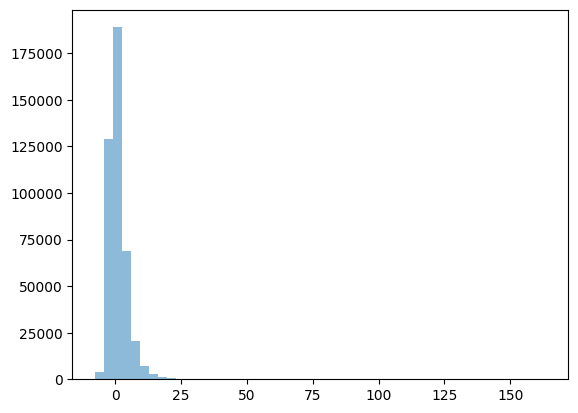

In [226]:
plt.hist(df_median_sol['median_score'], alpha=0.5, label='median_score', bins=50);

Simple vs median score normalized - the median distribution reflects the non normalized one

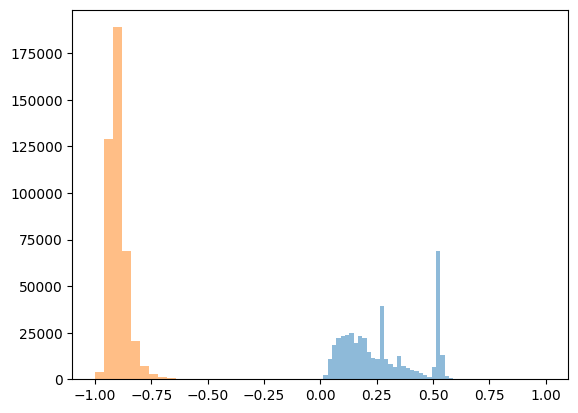

In [227]:
plt.hist(df_median_sol['simple_score'], alpha=0.5, label='simple_score', bins=50);
plt.hist(df_median_sol['median_score_normalized'], alpha=0.5, label='median_score_normalized', bins=50);

In [215]:
df_median_sol[(df_median_sol['simple_score']>0.5) & (df_median_sol['simple_score']<0.55)]\
[['used_incentive', 'incentive_value', 'basket_value', 'score', 'simple_score', 'median_score_normalized']].sort_values('simple_score').head(1000)

,used_incentive,incentive_value,basket_value,score,simple_score,median_score_normalized
276554,0.962963,15.497308,14.335769,0.142494,0.500023,-0.910134
203353,0.972973,6.610278,23.583333,-0.669097,0.500159,-0.919615
347934,0.958333,15.200435,22.605217,1.705007,0.500172,-0.891882
109407,0.956522,14.453182,27.477273,2.454337,0.500208,-0.883129
266970,0.954545,18.510000,20.404286,2.255797,0.500502,-0.885448
...,...,...,...,...,...,...
45569,1.0,1.600000,15.200000,-3.835333,0.506442,-0.9566
280664,1.0,5.570000,4.480000,-4.788333,0.506442,-0.967732
396917,1.0,7.000000,0.620000,-5.131333,0.506443,-0.971739
86441,1.0,6.790000,1.190000,-5.080333,0.506444,-0.971143


- With the median score, the people that used incentives only one with the orders are actually penalized, while with the simple score they have the highest propensity to use incentives.

# Order level

In [20]:
q='''
SELECT 
IFNULL(value.incentives.voucher_total_eur,0) as is_voucher_incentive_value, 
IFNULL(value.incentives.discount_dh_eur,0)+IFNULL(value.incentives.discount_other_eur,0) is_discount_incentive_value,
IFNULL(value.incentives.joker_customer_discount_eur,0) is_joker_incentive_value,
IFNULL(value.incentives.voucher_total_eur,0)+IFNULL(value.incentives.discount_dh_eur,0)+IFNULL(value.incentives.discount_other_eur,0)
+IFNULL(value.incentives.joker_customer_discount_eur,0) as total_incentive_value,
value.order.gmv_eur as basket_value, 
is_discount, 
is_voucher, 
is_joker,
is_free_delivery 
FROM `fulfillment-dwh-production.curated_data_shared_coredata_business.orders` 
WHERE is_successful = true and global_entity_id="FO_NO" and date(partition_date_local) = "2023-12-12"
'''

In [21]:
df = pandas_gbq.read_gbq(q)

Downloading: 100%|██████████|


In [22]:
df[df['is_joker']==True]
#print(len(df[df['is_discount']==True]))

,is_voucher_incentive_value,is_discount_incentive_value,is_joker_incentive_value,total_incentive_value,basket_value,is_discount,is_voucher,is_joker,is_free_delivery
23,0E-9,0E-9,3.800000000,3.800000000,13.010000000,True,False,True,True
57,0E-9,0E-9,3.800000000,3.800000000,13.690000000,True,False,True,True
74,0E-9,0E-9,3.800000000,3.800000000,13.770000000,True,False,True,True
93,0E-9,0E-9,8.450000000,8.450000000,28.560000000,True,False,True,True
152,0E-9,0E-9,3.800000000,3.800000000,14.280000000,True,False,True,True
...,...,...,...,...,...,...,...,...,...
14707,0E-9,0E-9,8.450000000,8.450000000,62.520000000,True,False,True,False
14719,0E-9,0E-9,8.450000000,8.450000000,58.630000000,True,False,True,False
14783,0E-9,0E-9,8.450000000,8.450000000,47.820000000,True,False,True,False
14819,0E-9,0E-9,8.450000000,8.450000000,52.470000000,True,False,True,False


In [23]:
def plot_hist(df, subset):
    df_sub = df[df[subset]==True]
    print("Share: %", round(len(df_sub)*100/len(df), 2))
    fig, ax = plt.subplots(figsize = (4,4))
    ax.hist(df_sub['total_incentive_value'], alpha=0.5, label='total_incentive_value')
    if subset!="is_free_delivery":
        ax.hist(df_sub[subset+'_incentive_value'], alpha=0.5, label='basket_value_incentive_specific')
    ax.hist(df_sub['basket_value'], alpha=0.5, label='basket_value')
    ax.legend(loc='upper right')
    plt.show()

def plot_all(df):
    for col in df.columns:
        if "value" not in col and "is_" in col and 'incentive_value' not in col:
            print(col)
            plot_hist(df, col)

is_discount
Share: % 22.97


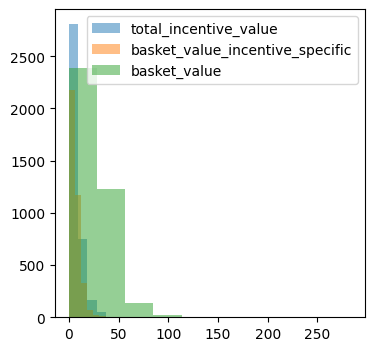

is_voucher
Share: % 10.5


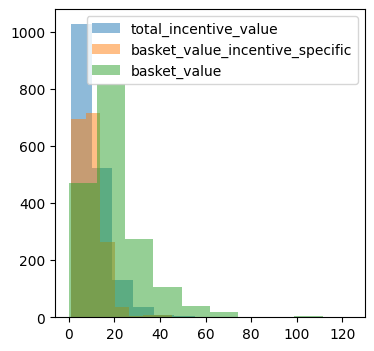

is_joker
Share: % 3.4


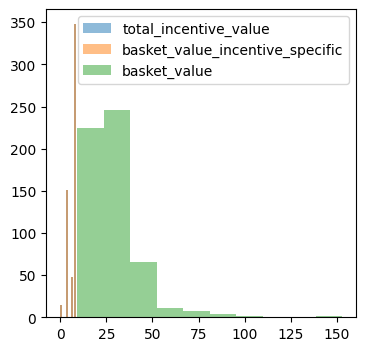

is_free_delivery
Share: % 28.78


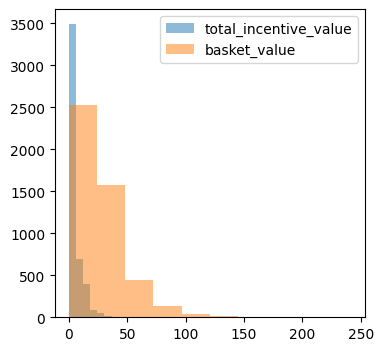

In [24]:
plot_all(df) #EUR

In [ ]:
df.columns

### Columns description:
#### Incentives
- **is_discount**: True if some other discount was given (**and used?**) to the customer (other than voucher and joker), e.g. Meal deal / Happy hour / Free drink / Pizza Montag / Free Delivery etc.	
- **is_voucher**: True if a voucher code was used, when the customer types in a code during the order process to receive a price reduction.	
- **is_free_delivery**: True if there was no delivery fee for the order.
- **is_joker**: True if the joker feature was used in the order process.
- **gmv_eur**: Gross Merchandise Value (GMV) is a metric that measures your total value of sales over a certain period of time. In this case we are calculating for each order the total amount Paid compulsory by Customer (also called MPR after DH Subsidy). Note that for top-level reporting this is calculated on Successful Orders, but not necessarily on Commissionable Orders. Includes VAT, all fees and incentives. Excludes Rider tip. Amount the customer paid (after vouchers and discounts, including delivery fee, allowance amount and **excluding tips**) in Euro.

For the discounts:
- **is_voucher_incentive_value**: we take the value.incentives.voucher_total_eur value which includes both DH vouchers and non
- **is_discount_incentive_value**: we sum discount_dh_eur and discount_other_eur because discount_total_eur also contains joker - also summing all the appropriate columns the result wil still differ from the "total" column due to rounding errors
- **is_joker_incentive_value**: the value is not null only if the joker feature was used in the order process (joker is a customized incentive, time limited)
- delivery free has no incentive value

Potentially interesting columns:
is_acquisition, is_corporate, is_qcommerce, value.incentives.wallet_total_eur

A way to differentiate dh vs vendor voucher value is to look at the respective voucher amount (the column contains a voucher amount breakdown).

To calculate the incentive value:
vouchers.amount_eur field is similar to value.incentives.voucher_total_eur (field I actually used), but in amount_eur the voucher value is divided against each voucher code/ campaign name.

Commission data info comes a month later, however January did not seem to have data for the day - but we are not interested in commission data.